# Phase 2: Feed-Forward Neural Network (FFNN)
## MATH 456 Final Project

**Author:** Helektra Katsoulakis | **Date:** December 2025

---
## Objectives:
1. Build FFNN from scratch and with PyTorch
2. Train on MNIST classification
3. Measure computational cost (FLOPs)
4. Analyze activation sparsity
5. Compare to LIF F-I curve

In [19]:
# Setup
%pip install torch torchvision --quiet

import ssl
ssl._create_default_https_context = ssl._create_unverified_context

import numpy as np
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import time
import warnings
warnings.filterwarnings('ignore')

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torchvision import datasets, transforms

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
torch.manual_seed(42)
np.random.seed(42)

%config InlineBackend.figure_format = 'retina'
plt.rcParams['figure.figsize'] = [10, 6]
print(f'Using device: {device}')
print('✓ Setup complete!')


[notice] A new release of pip is available: 25.1.1 -> 25.3
[notice] To update, run: pip3 install --upgrade pip
Note: you may need to restart the kernel to use updated packages.
Using device: cpu
✓ Setup complete!


## 2.1 Simple FFNN from Scratch

In [20]:
class SimpleFFNN:
    """Feed-forward neural network from scratch."""
    def __init__(self, input_size, hidden_size, output_size):
        self.W1 = np.random.randn(input_size, hidden_size) * 0.1
        self.b1 = np.zeros(hidden_size)
        self.W2 = np.random.randn(hidden_size, output_size) * 0.1
        self.b2 = np.zeros(output_size)
    
    def relu(self, x): return np.maximum(0, x)
    def sigmoid(self, x): return 1 / (1 + np.exp(-np.clip(x, -500, 500)))
    
    def forward(self, x):
        z1 = np.dot(x, self.W1) + self.b1
        a1 = self.relu(z1)
        z2 = np.dot(a1, self.W2) + self.b2
        return self.sigmoid(z2), a1

# Demo
ffnn = SimpleFFNN(3, 4, 2)
out, hidden = ffnn.forward(np.array([0.5, 0.3, 0.8]))
print(f'Input: [0.5, 0.3, 0.8]')
print(f'Hidden: {hidden.round(3)}')
print(f'Output: {out.round(3)}')
print('\n⚠️ ALL neurons compute on EVERY forward pass (dense computation)')

Input: [0.5, 0.3, 0.8]
Hidden: [0.    0.029 0.043 0.062]
Output: [0.496 0.498]

⚠️ ALL neurons compute on EVERY forward pass (dense computation)


## 2.2 Load MNIST Dataset

In [21]:
batch_size = 128
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

try:
    train_data = datasets.MNIST('./data', train=True, download=True, transform=transform)
    test_data = datasets.MNIST('./data', train=False, download=True, transform=transform)
    train_subset = torch.utils.data.Subset(train_data, range(10000))
    test_subset = torch.utils.data.Subset(test_data, range(2000))
    print('✓ MNIST loaded!')
except:
    print('Using synthetic data...')
    X_train = torch.randn(10000, 1, 28, 28)
    y_train = torch.randint(0, 10, (10000,))
    X_test = torch.randn(2000, 1, 28, 28)
    y_test = torch.randint(0, 10, (2000,))
    train_subset = TensorDataset(X_train, y_train)
    test_subset = TensorDataset(X_test, y_test)

train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_subset, batch_size=batch_size)
print(f'Train: {len(train_subset)}, Test: {len(test_subset)}')

✓ MNIST loaded!
Train: 10000, Test: 2000


## 2.3 PyTorch FFNN Model

In [22]:
class FFNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256, 10)
        self.relu = nn.ReLU()
        self.h1_act = None
        self.h2_act = None
    
    def forward(self, x):
        x = x.view(-1, 784)
        x = self.relu(self.fc1(x))
        self.h1_act = x.detach()
        x = self.relu(self.fc2(x))
        self.h2_act = x.detach()
        return self.fc3(x)
    
    def count_flops(self, batch=1):
        return (2*784*256 + 2*256*256 + 2*256*10) * batch

model = FFNN().to(device)
print(f'Parameters: {sum(p.numel() for p in model.parameters()):,}')
print(f'FLOPs/sample: {model.count_flops(1):,}')

Parameters: 269,322
FLOPs/sample: 537,600


## 2.4 Train FFNN

In [23]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

train_losses, train_accs = [], []
total_flops = 0

for epoch in range(5):
    model.train()
    loss_sum, correct, total = 0, 0, 0
    t0 = time.time()
    
    for data, target in train_loader:
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        out = model(data)
        loss = criterion(out, target)
        loss.backward()
        optimizer.step()
        
        loss_sum += loss.item()
        correct += (out.argmax(1) == target).sum().item()
        total += target.size(0)
        total_flops += model.count_flops(data.size(0))
    
    train_losses.append(loss_sum/len(train_loader))
    train_accs.append(100*correct/total)
    print(f'Epoch {epoch+1}: Loss={train_losses[-1]:.4f}, Acc={train_accs[-1]:.1f}%, Time={time.time()-t0:.1f}s')

print(f'\nTotal FLOPs: {total_flops:,}')

Epoch 1: Loss=0.5728, Acc=84.2%, Time=0.6s
Epoch 2: Loss=0.2250, Acc=93.4%, Time=0.6s
Epoch 3: Loss=0.1646, Acc=95.1%, Time=0.6s
Epoch 4: Loss=0.1141, Acc=96.6%, Time=0.6s
Epoch 5: Loss=0.0924, Acc=97.3%, Time=0.6s

Total FLOPs: 26,880,000,000


## 2.5 Evaluate FFNN

In [24]:
model.eval()
correct, total = 0, 0
t0 = time.time()

with torch.no_grad():
    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        out = model(data)
        correct += (out.argmax(1) == target).sum().item()
        total += target.size(0)

ffnn_accuracy = 100 * correct / total
ffnn_time = time.time() - t0
print(f'Test Accuracy: {ffnn_accuracy:.2f}%')
print(f'Inference Time: {ffnn_time*1000:.1f}ms')

Test Accuracy: 93.55%
Inference Time: 102.6ms


## 2.6 Analyze Activation Sparsity

In [25]:
model.eval()
h1_active, h2_active = [], []

with torch.no_grad():
    for data, _ in test_loader:
        data = data.to(device)
        _ = model(data)
        h1_active.append((model.h1_act > 0).float().mean().item())
        h2_active.append((model.h2_act > 0).float().mean().item())

h1_pct = np.mean(h1_active) * 100
h2_pct = np.mean(h2_active) * 100

print('='*50)
print('FFNN ACTIVATION SPARSITY')
print('='*50)
print(f'Hidden Layer 1: {h1_pct:.1f}% active')
print(f'Hidden Layer 2: {h2_pct:.1f}% active')
print(f'Average: {(h1_pct+h2_pct)/2:.1f}% active')
print('\n⚠️ Even with ReLU zeros, ALL neurons still COMPUTE!')

FFNN ACTIVATION SPARSITY
Hidden Layer 1: 58.0% active
Hidden Layer 2: 62.0% active
Average: 60.0% active

⚠️ Even with ReLU zeros, ALL neurons still COMPUTE!


## 2.7 Plot Training Curves

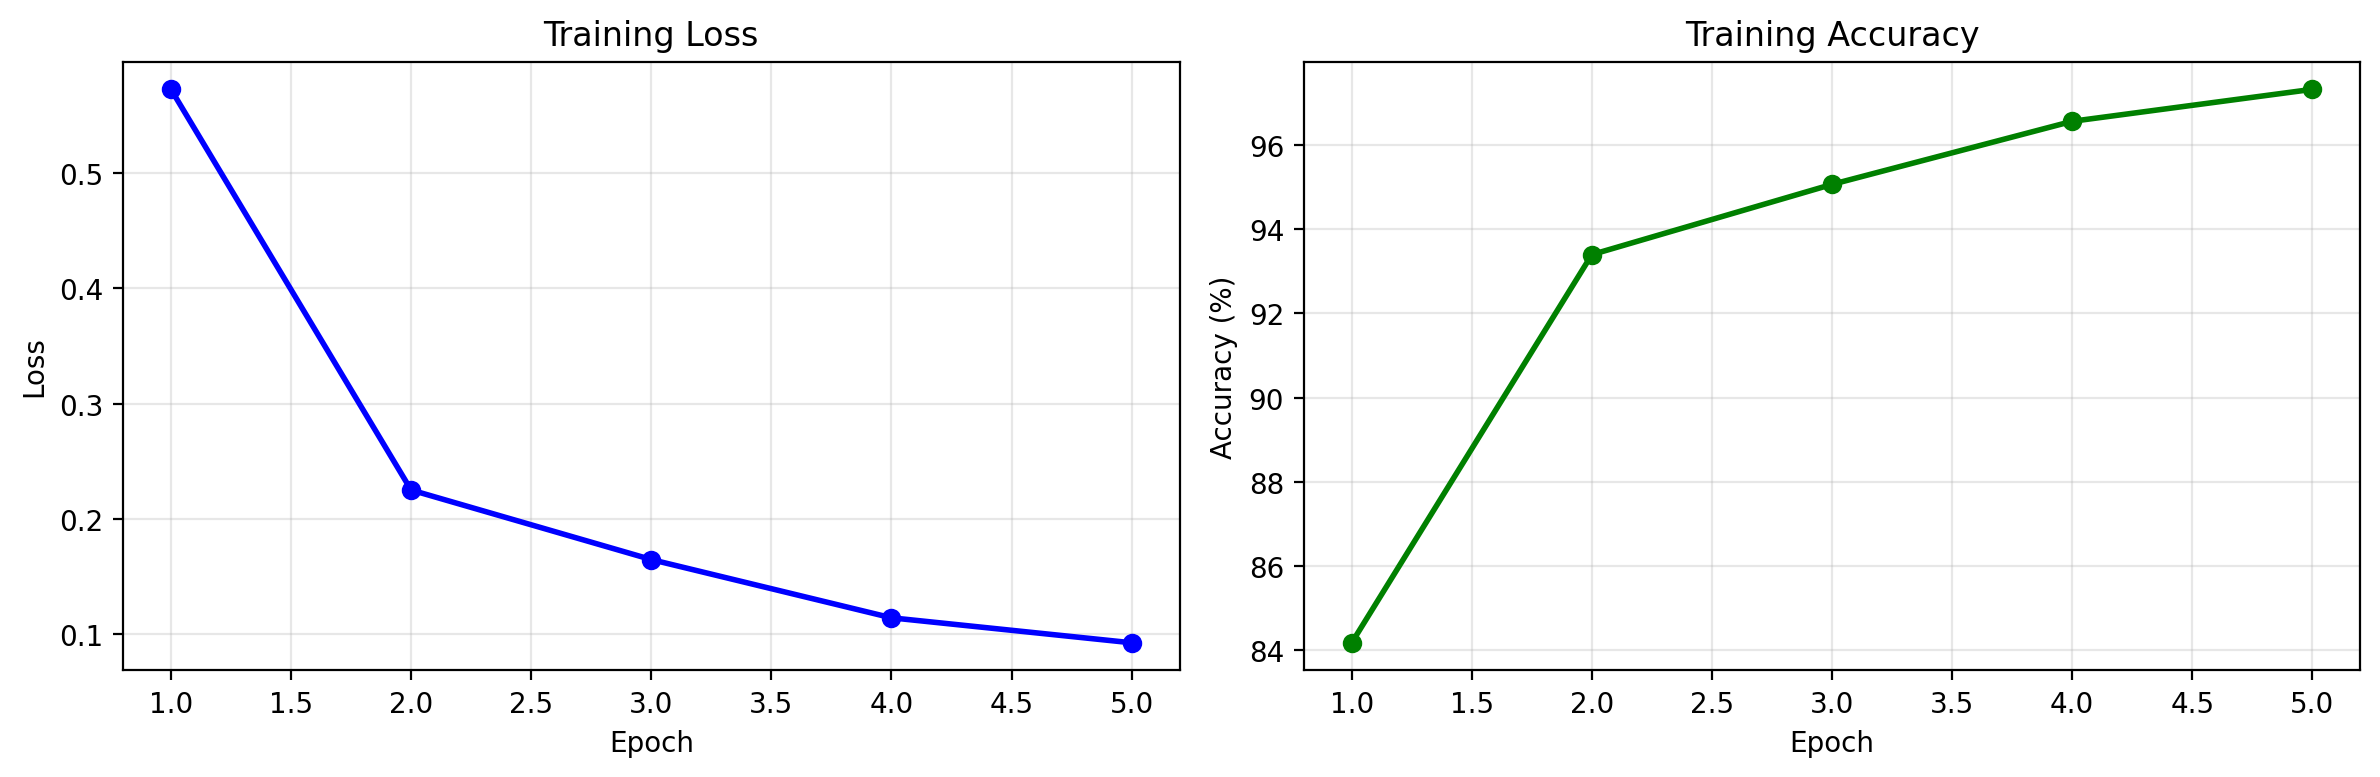

In [26]:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
epochs = range(1, len(train_losses)+1)

axes[0].plot(epochs, train_losses, 'b-o', lw=2)
axes[0].set_xlabel('Epoch')
axes[0].set_ylabel('Loss')
axes[0].set_title('Training Loss')
axes[0].grid(True, alpha=0.3)

axes[1].plot(epochs, train_accs, 'g-o', lw=2)
axes[1].set_xlabel('Epoch')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Training Accuracy')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 2.8 Save Results for Phase 3

In [27]:
# Save FFNN results
ffnn_results = {
    'accuracy': ffnn_accuracy,
    'inference_time': ffnn_time,
    'flops_per_sample': model.count_flops(1),
    'h1_active_pct': h1_pct,
    'h2_active_pct': h2_pct,
    'train_losses': train_losses,
    'train_accs': train_accs
}

np.savez('phase2_ffnn_results.npz', **{k: np.array(v) for k, v in ffnn_results.items()})
print('✓ Results saved to phase2_ffnn_results.npz')
print(f'\nSummary:')
print(f'  Accuracy: {ffnn_accuracy:.2f}%')
print(f'  FLOPs/sample: {model.count_flops(1):,}')
print(f'  Active neurons: {(h1_pct+h2_pct)/2:.1f}%')

✓ Results saved to phase2_ffnn_results.npz

Summary:
  Accuracy: 93.55%
  FLOPs/sample: 537,600
  Active neurons: 60.0%


---
## Phase 2 Complete!

**Key Findings:**
- FFNN uses dense computation (ALL neurons compute every time)
- ReLU creates some zero outputs, but computation still happens
- FLOPs per sample: ~533K operations

**Next: Phase 3 - Spiking Neural Network (SNN)**